In [1]:
# Add relative path to ExoJulia
push!(LOAD_PATH, "../../../ExoJulia/")

# import
using ExoJulia

In [2]:
using LsqFit
using PyPlot

In [3]:
# From time to M
M(t::Array,t_p::Float64,P::Float64) = (2*pi/P).*(t.-t_p)
M(t::Float64,t_p::Float64,P::Float64) = (2*pi/P)*(t-t_p)

M (generic function with 2 methods)

In [4]:
#How to convert from E to f
EtoF(E::Float64,ecc::Float64) = 2.*atan((((1.+ecc)/(1.-ecc))^(1./2.))*tan(E/2.))
EtoF(E::Array,ecc::Float64) = 2.*atan((((1.+ecc)/(1.-ecc))^(1./2.)).*tan(E./2.))

EtoF (generic function with 2 methods)

In [5]:
#Convert from linearized parameters to K
K(h::Float64,c::Float64) = sqrt(h*h+c*c)

K (generic function with 1 method)

In [6]:
#Convert from linearized parameters to pomega in degrees
pomega(h::Float64,c::Float64) = atand(-c/h)

pomega (generic function with 1 method)

In [7]:
#Convert from linearized parameters to gamma
gamma(v0::Float64,K::Float64,ecc::Float64,pomega::Float64) = v0-K*ecc*cosd(pomega)

gamma (generic function with 1 method)

In [8]:
#For periods between the average distance between data points and the time range of the data,
#sorts RVs by phase, and looks for the period that minimizes the sum of consecutive differences
#squared
function P_guesser(x_data::Array,y_data::Array)
    
    #Make an array from the minimum measurable period to the maximum measurable period, in steps
    #of half of a day
    P_array::Array{Float64} = collect(mean(diff(x_data)):0.5:maximum(x_data)-minimum(y_data))
    
    #Return the sum of squares of differences of consecutive RVs binned by period for each period
    sq_array::Array{Float64} = [sum(diff(y_data[sortperm(mod(x_data,P))]).^2.0) for P=P_array]
    
    #Return the period that results in the minimum of sq_array
    return P_array[findmin(sq_array)[2]]
    
end

P_guesser (generic function with 1 method)

In [9]:
#Slightly change kepler_solve! into a function that's compatible with arrays
function kepler_solve!(Ms::Array{Float64},ecc::Float64)
    results = Float64[]
    
    #For each M in the input, do kepler_solve!
    for em in Ms
        push!(results,ExoJulia.Orbit.kepler_solve!(em, ecc))
    end
    
    return results
    
end

kepler_solve! (generic function with 1 method)

In [10]:
#A function that, when given a series of f's, RV data and errors (all arrays of the same size)
#returns the linearized parameters h, c, and v0
#Follows prescription of Wright and Howard (2009)
function hcv0(f::Array{Float64},y_data::Array{Float64},y_error::Array{Float64})
    #Diagonal matrix of the inverse errors
    W = diagm(1.0./(y_error.^2.0))
    
    #[cos(f[1]) cos(f[2]) ... ;sin(f[1]) sin(f[2]) ... ; 1.0 1.0 ...]
    F = hcat(cos(f),sin(f),[1.0 for x in f])'
    
    #Error matrix
    epsilon = inv(F*W*F')
    
    #Return a (row) array of h, c, v0
    return y_data'*W*F'*epsilon
    
end

hcv0 (generic function with 1 method)

In [11]:
#Now we'll need a function to take a curve_fit object and convert to necessary parameters
function get_params(fit_obj::LsqFit.LsqFitResult{Float64},x_data::Array,y_data::Array,y_err::Array) 
    #returns e,t_p,P,K,pomega,gamma
    params::Array = fit_obj.param
    Es::Array = kepler_solve!(M(x_data,params[2],params[3]), params[1])
    f::Array = EtoF(Es,params[1])
    h,c,v0 = hcv0(f,y_data,y_err)
    return [params[1],params[2],params[3],K(h,c),pomega(h,c),gamma(v0,K(h,c),params[1], pomega(h,c))]
end

get_params (generic function with 1 method)

In [12]:
#Because we need to include hcv0 as a function of the RV data and errors, we'll need to nest our 
#fitting function inside of another function
function fit_RV(x_data::Array{Float64},y_data::Array{Float64},y_err::Array{Float64})
      
    #Define the radial velocity function
    function v_rad(t::Array{Float64},params::Array{Float64}) #params are e,t_p,P
            
            #Check to see if the eccentricity makes sense
            if 0 <= params[1] < 1
                
                #Convert the times into eccentric anomalies, then into true anomalies
                Es::Array{Float64} = kepler_solve!(M(t,params[2],params[3]),params[1])
                f::Array{Float64} = EtoF(Es,params[1])
                
                #Get h,c,v0. Note: these parameters are a function of f, which is a function of
                #e, t_p and P
                h,c,v0 = hcv0(f,y_data,y_err)
                
                #Return the radial velocities
                return h.*cos(f)+c*sin(f).+v0
                
            else
                return Inf
            end
    end
        
    #Now let's fit the v_rad function to y_data, weights are 1/err^2, initial guess is a small eccentricity,
    #the first time point, and the period returned by P_guesser. Then return our parameters
    return get_params(curve_fit(v_rad,x_data,y_data,(1.0./y_err.^2.0),[0.1,x_data[1],P_guesser(x_data,y_data)]),x_data,y_data,y_err)
        
end


fit_RV (generic function with 1 method)

In [13]:
#A function that, given parameters generated by fit_RV, generates v_rad at any given time
function get_v_rad_fit(times::Array,params::Array) 
        
    #Convert the times into eccentric anomalies, then into true anomalies
    Es::Array{Float64} = kepler_solve!(M(times,params[2],params[3]),params[1])
    f::Array{Float64} = EtoF(Es,params[1])
                
    #Get h,c,v0 from orbital parameters
    h = params[4]*cosd(params[5])
    c = -params[4]*sind(params[5])
    v0 = params[6]+params[4]*params[1]*cosd(params[5])
                
    #Return the radial velocities
    return h.*cos(f)+c*sin(f).+v0
    
end

get_v_rad_fit (generic function with 1 method)

In [14]:
#Read in data, separate into arrays
data = readdlm("mystery_planet.txt",Float64) 
times = data[:,1]
RVs = data[:,2]
RV_errs = data[:,3] ;

In [16]:
@time result = fit_RV(times,RVs,RV_errs) ;

  0.213481 seconds (346.02 k allocations: 96.684 MB, 6.52% gc time)


In [17]:
param_names = ["e","t_p","P","K","pomega","gamma"]
for (param,res) in zip(param_names,result)
    println("$param = $res")
end

e = 0.40016612320726774
t_p = 13891.356528538307
P = 116.68569506349166
K = 316.1090092004665
pomega = -0.7766860911621005
gamma = -51.916669565780765


In [43]:
function plot_RV(times::Array{Float64},rvs::Array{Float64},period::Float64,errors::Array{Float64},lab::ASCIIString;col="blue")
    phase = mod(times, period)/period;
    errorbar(phase, rvs, yerr = errors,color=col,fmt=".",label=lab)
end

function plot_RV(times::Array{Float64},rvs::Array{Float64},period::Float64,errors::Array{Float64};col="blue")
    phase = mod(times, period)/period;
    errorbar(phase, rvs, yerr = errors,color=col,fmt=".",)
end

function plot_RV(times::Array{Float64},rvs::Array{Float64},period::Float64,lab::ASCIIString;col="blue")
    phase = mod(times, period)/period;
    scatter(phase, rvs,marker="x",color=col,label=lab)
end

function plot_RV(times::Array{Float64},rvs::Array{Float64},period::Float64;col="blue")
    phase = mod(times, period)/period;
    scatter(phase,rvs,marker="x",color=col)
end

plot_RV (generic function with 4 methods)

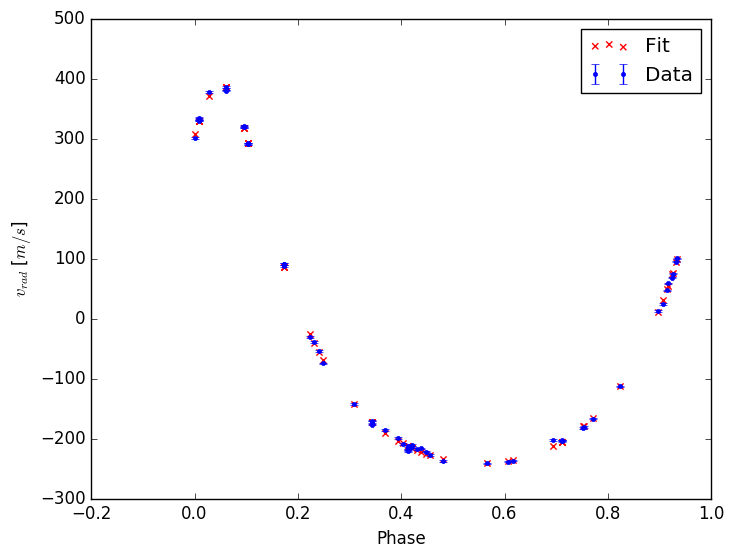

PyObject <matplotlib.text.Text object at 0x3272a25d0>

In [45]:
plot_RV(times,RVs,116.68569506349166,RV_errs,"Data",col="blue")
fitted_rv = get_v_rad_fit(times,result)
plot_RV(times,fitted_rv,116.68569506349166,"Fit",col="red")
legend(loc=0)
xlabel("Phase")
ylabel(L"$v_{rad}$ [$m/s$]")

In [20]:
function eff_func(t,t0::Float64,r0::Float64,sma::Float64,ecc::Float64,t_p::Float64,P::Float64)
    Ms = M(t,t_p,P)
    M0 = M(t0,t_p,P)
    E0 = kepler_solve!(M0,ecc)
    E = kepler_solve!(Ms,ecc)
    return (sma/r0).*(cos(E.-E0).+1)
end

eff_func (generic function with 1 method)

In [21]:
function gee_func(t,t0::Float64,r0::Float64,sma::Float64,ecc::Float64,t_p::Float64,P::Float64)
    Ms = M(t,t_p,P)
    M0 = M(t0,t_p,P)
    E0 = kepler_solve!(M0,ecc)
    E = kepler_solve!(Ms,ecc)
    return (t.-t0).+(P/(2.0*pi)).*(sin(E.-E0)-(E.-E0))
end

gee_func (generic function with 1 method)